<a href="https://colab.research.google.com/github/LucaPeg/Basket-market-LinkedIn/blob/main/basket_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set up enviornment, access Kaggle and download data

### Enviornment setup

In [1]:
!pip install pyspark
import pyspark
import os
import time
import matplotlib.pyplot as plt
from itertools import combinations
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("MarketBasket").getOrCreate()
sc = spark.sparkContext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.2-py2.py3-none-any.whl size=317812365 sha256=e69e4f9755a651880bb987bae8826d71bb6abfaa50b41d018826328953459fd7
  Stored in directory: /root/.cache/pip/wheels/34/34/bd/03944534c44b677cd5859f248090daa9fb27b3c8f8e5f49574
Successfully built pyspark


### Download and import data

In [2]:
# Access Kaggle
os.environ['KAGGLE_USERNAME'] = "xxxxxx"
os.environ['KAGGLE_KEY'] = "xxxxxx"

# Data download
!kaggle datasets download -d asaniczka/1-3m-linkedin-jobs-and-skills-2024
!unzip 1-3m-linkedin-jobs-and-skills-2024 -d data
# remove unnecessary data
!rm /content/data/linkedin_job_postings.csv
!rm /content/data/job_summary.csv
!rm /content/1-3m-linkedin-jobs-and-skills-2024.zip

Dataset URL: https://www.kaggle.com/datasets/asaniczka/1-3m-linkedin-jobs-and-skills-2024
License(s): ODC Attribution License (ODC-By)
 99% 1.87G/1.88G [00:18<00:00, 164MB/s]
100% 1.88G/1.88G [00:18<00:00, 110MB/s]
Archive:  1-3m-linkedin-jobs-and-skills-2024.zip
  inflating: data/job_skills.csv     
  inflating: data/job_summary.csv    
  inflating: data/linkedin_job_postings.csv  


In [3]:
# import data
df = spark.read.option('header','true').csv('/content/data/job_skills.csv')

### Exploratory Data Analysis (EDA)

In [4]:
# check the data
print(df.head())
print(df.printSchema())
print(df.show())

Row(job_link='https://www.linkedin.com/jobs/view/housekeeper-i-pt-at-jacksonville-state-university-3802280436', job_skills='Building Custodial Services, Cleaning, Janitorial Services, Materials Handling, Housekeeping, Sanitation, Waste Management, Floor Maintenance, Equipment Maintenance, Safety Protocols, Communication Skills, Attention to Detail, Physical Strength, Experience in Housekeeping')
root
 |-- job_link: string (nullable = true)
 |-- job_skills: string (nullable = true)

None
+--------------------+--------------------+
|            job_link|          job_skills|
+--------------------+--------------------+
|https://www.linke...|Building Custodia...|
|https://www.linke...|Customer service,...|
|https://www.linke...|Applied Behavior ...|
|https://www.linke...|Electrical Engine...|
|https://www.linke...|Electrical Assemb...|
|https://www.linke...|Access Control, V...|
|https://www.linke...|Consultation, Sup...|
|https://www.linke...|Veterinary Recept...|
|https://www.linke...|Op

In [5]:
df.describe()

DataFrame[summary: string, job_link: string, job_skills: string]

In [6]:
df = df.dropna() # 2007 NAs

In [7]:
df = df.drop("job_link") # we do not need this column

In [8]:
# Associate the data to a Resilient Distributed Dataset (RDD)
df_rdd = df.rdd

In [9]:
df_rdd.first()

Row(job_skills='Building Custodial Services, Cleaning, Janitorial Services, Materials Handling, Housekeeping, Sanitation, Waste Management, Floor Maintenance, Equipment Maintenance, Safety Protocols, Communication Skills, Attention to Detail, Physical Strength, Experience in Housekeeping')

In [10]:
df_rdd.getNumPartitions() # default is six partitions

6

In [11]:
df_rdd.first() # got to isolate the skills

Row(job_skills='Building Custodial Services, Cleaning, Janitorial Services, Materials Handling, Housekeeping, Sanitation, Waste Management, Floor Maintenance, Equipment Maintenance, Safety Protocols, Communication Skills, Attention to Detail, Physical Strength, Experience in Housekeeping')

In [12]:
skills = df_rdd.map(lambda x: x['job_skills'])
skills.first()

'Building Custodial Services, Cleaning, Janitorial Services, Materials Handling, Housekeeping, Sanitation, Waste Management, Floor Maintenance, Equipment Maintenance, Safety Protocols, Communication Skills, Attention to Detail, Physical Strength, Experience in Housekeeping'

### Basket creation

In [13]:
skills = skills.map(lambda word: word.lower())
skills = skills.map(lambda line: line.split(', '))
skills.first()

['building custodial services',
 'cleaning',
 'janitorial services',
 'materials handling',
 'housekeeping',
 'sanitation',
 'waste management',
 'floor maintenance',
 'equipment maintenance',
 'safety protocols',
 'communication skills',
 'attention to detail',
 'physical strength',
 'experience in housekeeping']

In [14]:
lens = skills.map(lambda x: len(x))
print(f"Min number of skills required is {lens.min()}") # these take forever (1)
print(f"Max number of skills required is {lens.max()}") # (463)

Min number of skills required is 1
Max number of skills required is 463


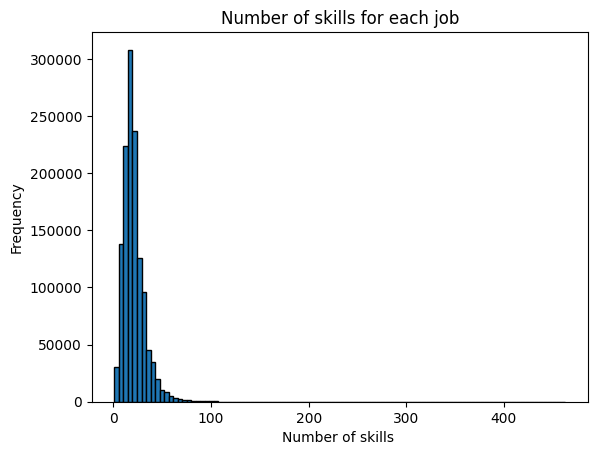

In [15]:
plt.hist(lens.collect(), bins=100, edgecolor='black') # .collect is plottable
plt.xlabel("Number of skills ")
plt.ylabel('Frequency')
plt.title('Number of skills for each job')
plt.show()

### Hashing
I transform the skills names in integers by hashing

In [16]:
# get all unique skills
unique_skills = skills.flatMap(lambda x: x).distinct().collect() # list


In [17]:
# get dictionary to link each skill to an integer
skill_to_int = {skill: idx for idx, skill in enumerate(unique_skills)}

In [18]:
skills_int = skills.map(
    lambda skills_integers: [skill_to_int[skill] for skill in skills_integers])

In [19]:
baskets = skills_int.map(lambda skill_list: set(skill_list)) # now I have sets

In [20]:
# Check if smth went wrong because I'm paranoid
print(set(skills_int.first()) == baskets.first()) #sets are unordered

True


In [21]:
baskets.first()

{0,
 1,
 2,
 462123,
 462124,
 923331,
 1385287,
 1385288,
 1847540,
 1847541,
 1847542,
 1847543,
 1847544,
 2309149}

## A Priori Algorithm
I will implement two stages:
* **First pass**
** Inspect each basket and takes the count of each
skill
**   Assess the frequent singletons according to threshold
* **Second pass**
** Generate pairs of all frequent items
** For each pair, count how many times it occures
** Select the frequent pairs

In [22]:
def apriori(baskets_collections, threshold_percentage, hash_table):
  # define the absolute frequency threshold based on the provided percentage
  threshold = baskets_collections.count()*threshold_percentage
  # FIRST STAGE ################################################################
  # flatmap: each skill in a basket is flatted into a tuple: (skill, 1)
  # reducedByKey: all the tuples are aggregated: all the 1s are added (x+y)
  # filter: we select only the counts (x[1]) greater than the threshold
  l1 = baskets_collections.flatMap(lambda basket: [(skill,1) for skill in basket]) \
                                .reduceByKey(lambda x,y: x+y) \
                                .filter(lambda x: x[1]>threshold)

  # get how many singletons are frequent
  car_l1 = l1.count() # cardinality of L1 (actual freq singletons)

  print(f"FIRST STAGE:")
  print(f"With threshold = {threshold_percentage} there are {car_l1} frequent singletons")

  # find the 3 most frequent singletons -> go back to hash table (skill_to_int)
  top_3_frequent = l1.takeOrdered(3, key=lambda x: -x[1])

  # reverse the skill_to_int dictionary
  # I use "Unknown" to avoid issues if the skill id is not in the hash table
  # However there should not be any issues and it could be avoided
  int_to_skill = {v: k for k, v in skill_to_int.items()}
  top_3_names = [(int_to_skill.get(skill_id, 'Unknown'), count) \
                 for skill_id, count in top_3_frequent]

  # print results
  print(f"Top 3 most frequent singletons:")
  for skill_name, count in top_3_names:
      print(f"\t{skill_name} : {count}")


  # SECOND STAGE (and all the others) ########################################
  freq_itemset_counts = l1
  stage = 2 # initialized

  while True:
      print(f"\nSTAGE {stage}: Find frequent itemsets of size {stage}")

      frequent_items = set(freq_itemset_counts.map(lambda x: x[0]).collect())
      # within the baskets, keep only the frequent items
      filtered_baskets = baskets_collections.map(
          lambda basket: [item for item in basket if item in frequent_items]
      )

      # generate pairs, triple, etc (each combination of frequent items)
      candidates = filtered_baskets.flatMap(
          lambda basket: list(combinations(sorted(basket), stage))
      )
      itemset_counts = candidates.map(lambda itemset: (itemset, 1)).reduceByKey(lambda x, y: x + y)

      # filtering frequent items
      frequent_itemset = itemset_counts.filter(lambda x: x[1] > threshold)
      itemset_cardinality = frequent_itemset.count()

      if itemset_cardinality == 0:
          print(f"\tThere are no frequent itemsets of size {stage}")
          break
      else:
          frequent_itemsets_names = frequent_itemset.map(
              lambda x: (tuple(int_to_skill.get(skill_id, 'Unknown') for skill_id in x[0]), x[1])
          ) # get is useful to avoid KeyError, although it should happen here
          top_3_itemsets = frequent_itemsets_names.takeOrdered(3, key=lambda x: -x[1])

          # print results
          print(f"With threshold = {threshold_percentage}, there are {itemset_cardinality} frequent itemsets of size {stage}.")
          print(f"Top 3 frequent itemsets of size {stage}:")
          for itemset, count in top_3_itemsets:
              print(f"\t{itemset}: {count}")

          stage += 1 # move to next stage

In [23]:
start_time = time.time()
apriori(baskets,0.02, skill_to_int)
end_time = time.time()
time_taken = end_time - start_time
print(time_taken)

FIRST STAGE:
With threshold = 0.02 there are 80 frequent singletons
Top 3 most frequent singletons:
	communication : 365844
	customer service : 276404
	teamwork : 225953

STAGE 2: Find frequent itemsets of size 2
With threshold = 0.02, there are 67 frequent itemsets of size 2.
Top 3 frequent itemsets of size 2:
	('teamwork', 'communication'): 139150
	('customer service', 'communication'): 138992
	('leadership', 'communication'): 117141

STAGE 3: Find frequent itemsets of size 3
With threshold = 0.02, there are 25 frequent itemsets of size 3.
Top 3 frequent itemsets of size 3:
	('teamwork', 'customer service', 'communication'): 63922
	('teamwork', 'problemsolving', 'communication'): 51228
	('teamwork', 'leadership', 'communication'): 50878

STAGE 4: Find frequent itemsets of size 4
	There are no frequent itemsets of size 4
792.0032169818878
